# SED Interpolation

Here I interpolate the SED linearly to have a time step of 0.5 day instead of 1 day.

__Note:__ I round the fluxes at some point for visualization purposes, i.e., to deal with the anoying large decimals returned by python, so check the flux scaled of the SED you are using.

In [70]:
import numpy as np
import pandas as pd

sed_info = pd.read_csv('templates/conley09f/snflux_1a.dat', names=['phase', 'wave', 'flux'], delim_whitespace=True)
phases, waves, fluxes = [sed_info.phase.values, sed_info.wave.values, sed_info.flux.values]
sed_info.head(3)

,phase,wave,flux
0,-20.0,1000.0,3.533845e-38
1,-20.0,1010.0,3.533845e-38
2,-20.0,1020.0,3.533845e-38


In [71]:
time_step = 0.5
interp_phases = np.arange(sed_info.phase.min(), sed_info.phase.max()+time_step, time_step)

In [72]:
sed_dict = {'phase':np.empty(0), 'wave':np.empty(0), 'flux':np.empty(0)}

for wave in sed_info.wave.unique():
    sed = sed_info[sed_info.wave.values==wave]
    interp_flux = np.interp(interp_phases, sed.phase.values, sed.flux.values)
    
    sed_dict['phase'] = np.r_[sed_dict['phase'], interp_phases]
    sed_dict['flux'] = np.r_[sed_dict['flux'], interp_flux]
    sed_dict['wave'] = np.r_[sed_dict['wave'], [wave]*len(interp_phases)]

In [81]:
sed

,phase,wave,flux
2294,-20.0,23940.0,3.533703e-38


In [104]:
sed_df = pd.DataFrame.from_dict(sed_dict)
sed_df = sed_df[['phase', 'wave', 'flux']]
sed_df = sed_df.sort_values(by=['phase', 'wave'])
sed_df.flux = sed_df.flux.round(45)  # for visualization purposes
sed_df.head()

,phase,wave,flux
0,-20.0,1000.0,3.533845e-38
211,-20.0,1010.0,3.533845e-38
422,-20.0,1020.0,3.533845e-38
633,-20.0,1030.0,3.533845e-38
844,-20.0,1040.0,3.533845e-38


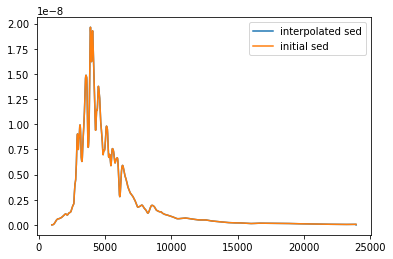

In [105]:
import matplotlib.pyplot as plt

orig_data = sed_info[sed_info.phase.values==0.0]
orig_waves, orig_fluxes = [orig_data.wave.values, orig_data.flux.values]

data = sed_df[sed_df.phase.values==0.0]
waves, fluxes = [data.wave.values, data.flux.values]
plt.plot(waves, fluxes, label='interpolated sed')
plt.plot(orig_waves, orig_fluxes, label='initial sed')
#plt.plot(orig_waves, fluxes[:-1]-orig_fluxes)
plt.legend();

In [106]:
sed_df.to_csv('templates/conley09f/snflux_1av2.dat', sep='\t', index=False, header=False)

In [14]:
import numpy as np
import pandas as pd
import piscola as pisco

sed_info = pd.read_csv('../piscola/src/piscola/templates/jla/snflux_1a.dat', names=['phase', 'wave', 'flux'], delim_whitespace=True)
sed_info = sed_info[sed_info.phase==0]
phases, waves, fluxes = [sed_info.phase.values, sed_info.wave.values, sed_info.flux.values]
sed_info.head(3)

sed_info0 = pd.read_csv('../../SNANA/SNDATA_ROOT/snsed/Hsiao07.extrap.dat', names=['phase', 'wave', 'flux'], delim_whitespace=True)
sed_info0 = sed_info0[sed_info0.phase==0]
phases0, waves0, fluxes0 = [sed_info0.phase.values, sed_info0.wave.values, sed_info0.flux.values]
sed_info0.head(3)

,phase,wave,flux
49420,0.0,300.0,0.0
49421,0.0,310.0,0.0
49422,0.0,320.0,0.0


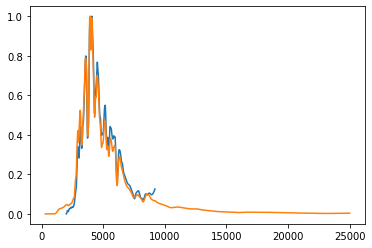

In [15]:
import matplotlib.pyplot as plt

plt.plot(waves, fluxes/fluxes.max())
plt.plot(waves0, fluxes0/fluxes0.max());

In [16]:
bwave, bflux = np.loadtxt('../piscola/src/piscola/filters/Bessell/Bessell_B.dat').T

In [17]:
f = pisco.run_filter(waves, fluxes/fluxes.max(), bwave, bflux)
f0 = pisco.run_filter(waves0, fluxes0/fluxes0.max(), bwave, bflux)

In [18]:
-2.5*np.log10(f/f0)

-0.060671021334457856

Best-fitting slope =  -0.10304347826086957
Chi^2 =  2.733468048346203
Reduced Chi^2 = 0.39049543547802895


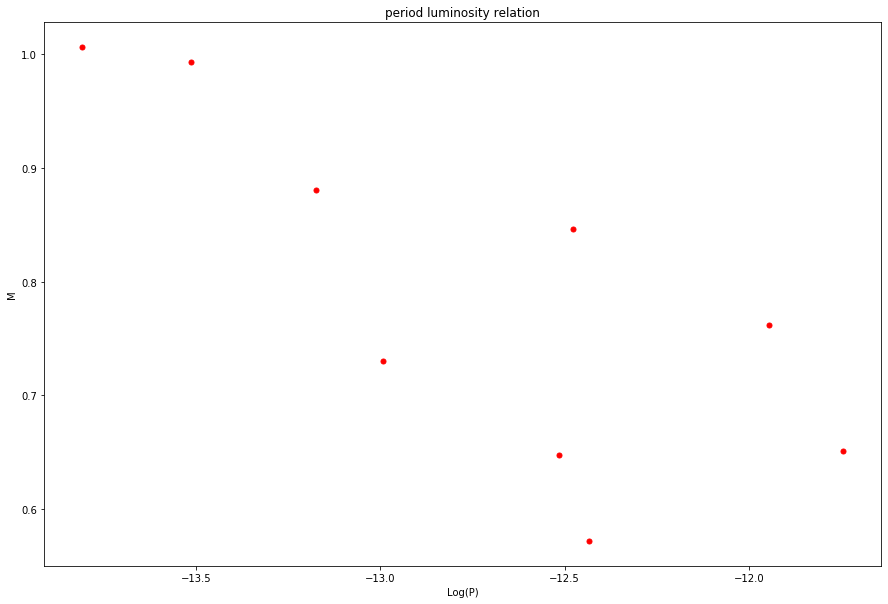

In [23]:
 from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt
import pylab

#I disgarded one of the data points as it was a clear outlier and would have affected my chi squared
d_error=np.array([0.18,0.16,0.2,0.18,0.29,0.15,0.18,0.23,0.19])
A_error=np.array([0.03,0.05,0.03,0.1,0.04,0.03,0.06,0.06,0.08])
d=1000/(np.array([2.78,3.14,2.28,3.00,2.13,3.66,2.81,1.90,2.40 ]))
m=np.array([3.911,3.751,4.667,4.556,5.743,3.960,5.372,5.752,5.464])
A=np.array([0.06,0.25,0.37,0.58,0.67,0.23,0.64,0.34,0.20])
P=np.array([10.15073,9.842425,7.594904,7.012877,5.77338,5.36627,4.470916,4.435462,3.72819])
M=m-5.0*np.log10(d)-5+A
x=np.log10(P)
plt.xlabel('Log(P)')
plt.ylabel('M')
plt.title('period luminosity relation')
plt.plot(M, x ,color='red', marker='o', markersize=5, linestyle="None")          
pylab.rcParams['figure.figsize'] = (15.0, 10.0)
#turn interactive plotting mode on
plt.ioff()
y=M
#a=starting slope
#b=starting intercept  
def func(x,a,b):
    """calculates the model"""
    equation= b + a*x
    return equation
#y_m is the predicted y values according to the chi squared distribution
def chisq(y, sig_y, y_m):
    """takes model, data and error vectors and calculates the chi2"""
    chi2 = np.sum(((y-y_m)**2.0)/(sig_y**2.0))
    return chi2



#I estimated the slope and intercept on the graph itself. This code was adapted from lesson 14 in the workbook
a=-237/2300
b=1.18
sigma=(d_error)**2*(-5/d)**2+(A_error)**2
y_m = a*x + b
#set up the sigmas as a 1-D vector of the same size as x and y
sig_y = x*0 + sigma
err_y = np.random.normal(0.0, sig_y, x.size)
y = y_m + err_y
dof = len(x)-2.0 #the number of degrees of freedom M=N-M number of data points-number of parameters

p0=None


#now I find the best model with curve_fit
#start_slope = -237/2300
#start_intercept=1.18 #this is my starting parameters for the LM algorithm
best_parameters, rough = opt.curve_fit(func,x, y, sigma=sig_y,p0=(a,b), absolute_sigma=True)

#I now calculated the minimum chi squared
best_slope=a
best_intercept=b
y_best=func(x, best_parameters[0], best_parameters[1])
best_parameters[0]=best_slope
best_parameters[1]=best_intercept
best_chi= np.sum(((y-y_best)**2.0)/(sig_y**2.0))


#plt.plot(x,y_best,color="red", linewidth=2)
#plt.errorbar(x, y_best, sig_y, color="red", linewidth=2, linestyle="None")


print('Best-fitting slope = ', a)
print('Chi^2 = ', best_chi)
print('Reduced Chi^2 =', best_chi/dof)

plt.show()

In [22]:
y_best

array([1.07655314, 1.07794024, 1.08959817, 1.09318379, 1.10193048,
       1.10521906, 1.1134283 , 1.11378635, 1.12159844])